In [39]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import fiona
import rasterio as rio
from rasterio import plot, mask
from rasterstats import zonal_stats

# Import polygons

In [23]:
# import landslide polygons
shapefile_shx = "../0-brute-raw-data/Landslides.shx"
nz_landslide_polygons = gpd.read_file(shapefile_shx, SHAPE_RESTORE_SHX = "YES")

In [4]:
%matplotlib inline

<Axes: >

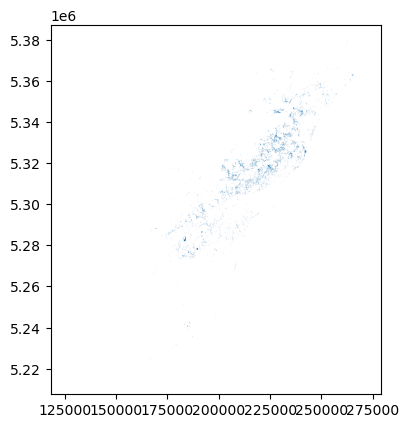

In [24]:
nz_landslide_polygons.plot()

# Match crs

In [25]:
test_src = rio.open('../1-raw-data/ndvi/LC08_L2SP_073089_20161215_20200905_02_T1_ndvi')
ndvi_crs = test_src.crs

In [26]:
nz_landslide_polygons.crs

<Projected CRS: EPSG:32760>
Name: WGS 84 / UTM zone 60S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 174°E and 180°E, southern hemisphere between 80°S and equator, onshore and offshore. New Zealand.
- bounds: (174.0, -80.0, 180.0, 0.0)
Coordinate Operation:
- name: UTM zone 60S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
nz_landslide_reprojected = nz_landslide_polygons.to_crs(ndvi_crs)
nz_landslide_reprojected.crs

<Projected CRS: EPSG:32659>
Name: WGS 84 / UTM zone 59N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 59N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
r= test_src.read(1, masked = True)

<Axes: >

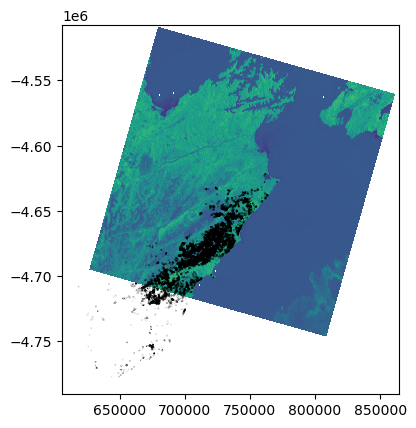

In [29]:
ndvi_extent = rio.plot.plotting_extent(test_src)

f, ax = plt.subplots()
ax.imshow(r, extent=ndvi_extent)
nz_landslide_reprojected.plot(ax=ax, facecolor='y', edgecolor='k')

#plt.colorbar()

In [30]:
test_src.nodata

999.9000244140625

In [31]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
nz_ma, nz_ma_transform = rio.mask.mask(test_src, nz_landslide_reprojected.geometry, **rio_mask_kwargs)
nz_ma_extent = rio.plot.plotting_extent(nz_ma, nz_ma_transform)

<Axes: >

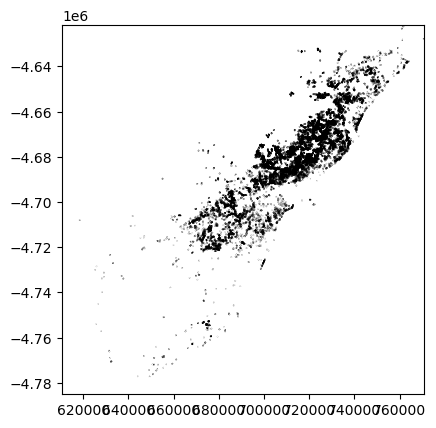

In [32]:
f, ax = plt.subplots()
ax.imshow(nz_ma, extent=nz_ma_extent)
nz_landslide_reprojected.plot(ax=ax, facecolor='none', edgecolor='k')

In [42]:
zonalstats = zonal_stats(nz_landslide_reprojected, raster=r, affine=test_src.transform,nodata=test_src.nodata,
            stats="mean")
zonal_df = pd.DataFrame(zonalstats, columns = ['mean'])
nz_landslide_reprojected = nz_landslide_reprojected.join(zonal_df)
nz_landslide_reprojected.head()

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,geometry,mean
0,1,1,6294.572688,971012.709717,971012.709717,None,None,"POLYGON ((719299.877 -4678794.256, 719307.478 ...",0.028924
1,2,0,534.474179,6510.391251,6510.391251,None,None,"POLYGON ((719213.776 -4679545.646, 719214.183 ...",0.031918
2,3,0,1600.066686,46399.058635,46399.058635,None,None,"POLYGON ((718924.785 -4679846.765, 718916.619 ...",0.033401
3,4,0,1645.958267,34457.252781,34457.252781,None,None,"POLYGON ((719014.603 -4680640.581, 719006.256 ...",0.107371
4,5,0,316.753483,4571.300600,4571.300600,None,None,"POLYGON ((719098.802 -4680300.165, 719111.566 ...",0.125787
